In [1]:
# Packages
using Plots, LinearAlgebra, SimpleDifferentialOperators

# Discretizing Time-Independent Linear Operators without Control

This is a tutorial that demonstrates how to discretize a linear operator of a time-independent diffusion process without any control. As an example a univariate diffusion process is utilized and the corresponding  Hamilton-Jacobi-Bellman equation is solved.

Notation:

- ``\mathcal{A}`` is an operator (or infinitesimal generator) associated with a particular stochastic process.

- ``q^{-} \equiv \min\{q,0\}``

- ``q^{+} \equiv \max\{q,0\}``

- Derivatives are denoted by the operator ``\partial`` and univariate derivatives are denoted as ``\partial_x v(x) = v'(x)``

###### Grids:

- For the univariate case, ``x\in [\underline{x}, \overline{x}]`` we will discretize ``x`` with ``I`` uniformly spaced points by ``\{x_i\}_{i=1}^I`` such that ``x_1 = \underline{x}`` and ``x_I=\overline{x}``. The distance between consecutive points is denoted by ``\Delta = x_{i+1}-x_i``.

### Time Independent Univariate Diffusion

Assume that the time variable does not directly enter into anything important in the problem (e.g. drifts, payoff, stopping values, boundary values, or discount rates). This is also assuming that the drift, payoffs, stopping value are not a (direct) function of any ``v_i``. Otherwise, the operator would be nonlinear. In the case of a linear ``\mathcal{A}``, the resulting discretized operator will be a (heavily sparse) matrix ``A\in\mathbb{R}^{I\times I}``, which is especially convenient to solve.

#### Stochastic Process and Boundary Values

Take a diffusion process for ``x_t`` according to the following stochastic difference equation,

```math
\begin{equation}
dx_t = \mu(x_t)dt + \sigma(x_t)d\mathbb{W}_t
\end{equation}
```

where ``\mathbb{W}_t`` is Brownian motion and ``x\in [\underline{x}, \overline{x}]`` where ``-\infty \leq \underline{x}<\overline{x}\leq \infty``. The functions ``\mu(\cdot)`` and ``\sigma(\cdot)`` are left general, but it is essential that they are time-homogenous.

For instance, we can have the following functions ``\mu(\cdot)`` and ``\sigma(\cdot)``:

- ``\mu(x) = -0.01x``

- ``\sigma(x) = 0.1x``

In [2]:
function μ(x)
    return -0.01*x
end

function σ2(x)
    return (0.1*x)^2
end

σ2 (generic function with 1 method)

The partial differential operator (infinitesimal generator) associated with the stochastic process in (1) is

```math
\begin{equation}
\mathcal{A} \equiv \mu(x)\partial_x + \frac{\sigma(x)^2}{2}\partial_{xx}
\end{equation}
```

Since the process is univariate, we require boundary conditions at both sides of ``x``, and assume that the boundary and ``\mu(\cdot)`` and ``\sigma(\cdot)^2`` are independent of time. For this tutorial we will consider the boundary values of a reflecting barrier, for sides of ``x``, for an operator on a generic function ``v(\cdot)``.

For reflecting barriers at both sides of ``x`` we have the following boundary values:

- ``\partial_{x}v(\underline{x}) = v'(\underline{x}) = 0 ``

- ``\partial_{x}v(\overline{x}) = v'(\overline{x}) = 0 ``

### Example Problem

Using ``\mu(\cdot)`` and ``\sigma(\cdot)`` as defined earlier

- ``\mu(x) = -0.01x``

- ``\sigma(x) = 0.1x``

to define the stochastic difference equation

```math
\begin{equation}
dx_t = \mu(x_t)dt + \sigma(x_t)d\mathbb{W}_t
\end{equation}
```

we can consider the problem where:

- Utility function: ``u(x) = \log(x)``

- Left Boundary: ``\underline{x} = 0.01``

- Right Boundary: ``\overline{x} = 10``

- Discount factor: ``\rho = 0.05``

Note that the choices of ``\mu(\cdot)``, ``\sigma(\cdot)``, and ``u(\cdot)`` render this particular problem control-free. That is, the state variable ``x_t`` determines the drift and variance of the stochastic process along with determining the utility without any control by the agent.

We can then discretize ``[\underline{x},\overline{x}]=[0.01,10]`` by increments of ``0.001``.

In [3]:
x_min = 0.01
x_max = 10

grid = x_min:0.001:x_max

function u(x)
    return log(x)
end

ρ = 0.05

0.05

### Solving Control-Free Time-Independent Linear Hamilton-Jacobi Bellman Equation

In the simple case of an uncontrolled linear stochastic process with no optimal stopping, if an agent has payoff ``u(x)`` with discounting ``\rho>0``, then the following Hamilton-Jacobi Bellman equation determines the value

```math
\begin{equation}
\rho v(x) = u(x) + \mathcal{A}v(x)
\end{equation}
```

subject to the appropriate boundary conditions. Discretizing the grid, let ``u \equiv \{u(x_i)\}_{i=1}^I\in\mathbb{R}^I``, where ``v\in\mathbb{R}^I`` is unknown, then the discretized version is,

```math
\begin{equation}
\rho v = u + Av
\end{equation}
```

where ``A`` is a discretization of ``\mathcal{A}`` on ``\{x_i\}_{i=1}^I``. Note that ``A`` necessarily must account for the boundary values of the grid.

Next, we can solve algebraically for ``v`` as the linear system:

```math
\begin{equation}
(\rho I -A)v = u
\end{equation}
```

We will construct the discretized operator ``A`` using the SimpleDifferentialOperators package. Since the drift of the stochastic process (1) is always negative in our example on ``[0.01,10.0]`` we will only utilize the downwind drift discretization ``L_{1-}``. We note that the resulting matrix ``A`` is a tridiagonal matrix, making it particularly convenient to solve numerically.

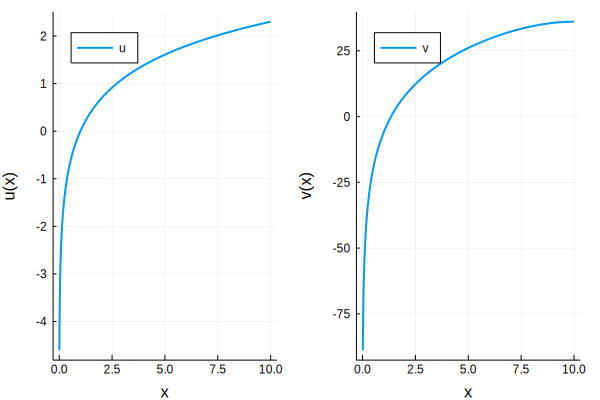

In [4]:
bc = (Reflecting(), Reflecting())

A = μ.(grid).*L₁₋(grid, bc) + (σ2.(grid)/2).*L₂(grid, bc)

v = (ρ*I - A)\ u.(grid)

plt_u = plot(grid, u.(grid), label="u", xlabel="x", ylabel = "u(x)", lw=2, legend=:topleft)
plt_v = plot(grid, v, label="v", xlabel="x", ylabel="v(x)", lw=2, legend=:topleft)
plot(plt_u,plt_v)

### Appendix: Upwind Finite Difference Discretization of the Differential Operator with a Uniform Grid

Here, we will manually use finite difference to discretize ``\mathcal{A}`` in order to construct ``A`` as a means to solving the HJBE. We note that utilizing the SimpleDifferentialOpperators package avoids this (tedious) derivation.

Note that

```math
\begin{equation}
\mathcal{A}v=\mu(x) v_x + \frac{\sigma^2(x)}{2}v_{xx}
\end{equation}
```

Next, we will proceed to derive an upwind finite difference scheme for ``\mathcal{A}v``. In particular we will employ a uniformly spaced discretization of ``[\underline{x},\overline{x}]``. Denote this discretization of ``[\underline{x},\overline{x}]`` with ``I`` uniformly spaced points as ``x \equiv \{x_i\}_{i=1}^I``, where ``x_1 = \underline{x}`` and ``x_I=\overline{x}``. We will denote the distance between consecutive points by ``\Delta = x_{i+1}-x_i``.

Then for an interior ``x_i``, that is ``i\in[2,I-1]``, ``\mathcal{A}v(x_i)`` can be discretized as such:

```math
\begin{equation}
\mathcal{A}v(x_i)\approx \mu_i^+(\frac{v_{i+1}-v_{i}}{\Delta}) + \mu_i^-(\frac{v_i-v_{i-1}}{\Delta}) +\frac{\sigma^2_i}{2}\frac{v_{i+1}-2v_i+v_{i-1}}{\Delta^2}
\end{equation}
```

such that the upwind scheme chooses forward or backward difference depending on the sign of the drift.

We can collect the above terms such that:

```math
\begin{equation}
\mathcal{A}v(x_i)\approx (-\frac{\mu_i^-}{\Delta}+\frac{\sigma^2_i}{2\Delta^2})v_{i-1} + (\frac{\mu_i^-}{\Delta} - \frac{\mu_i^+}{\Delta}-\frac{\sigma^2_i}{\Delta^2})v_i + (\frac{\mu_i^+}{\Delta}+\frac{\sigma^2_i}{2\Delta^2})v_{i+1}
\end{equation}
```

For the boundary value at ``\underline{x}``, consider the ghost node ``x_0``. Then the approximation of ``\mathcal{A}v(x_1)`` is:

```math
\begin{equation}
\mathcal{A}v(x_1)\approx (-\frac{\mu_1^-}{\Delta}+\frac{\sigma^2_1}{2\Delta^2})v_{0} + (\frac{\mu_1^-}{\Delta} - \frac{\mu_1^+}{\Delta}-\frac{\sigma^2_1}{\Delta^2})v_1 + (\frac{\mu_1^+}{\Delta}+\frac{\sigma^2_1}{2\Delta^2})v_{2}
\end{equation}
```

Since ``v'(\underline{x}) = 0`` then ``v'(\underline{x})`` can be approximated since ``v'(\underline{x}) = \frac{v_1-v_0}{\Delta} = 0``, then ``v_0 = v_1``. Then:

```math
\begin{equation}
\mathcal{A}v(x_1)\approx [(-\frac{\mu_1^-}{\Delta}+\frac{\sigma^2_1}{2\Delta^2}) + (\frac{\mu_1^-}{\Delta} - \frac{\mu_i^+}{\Delta}-\frac{\sigma^2_1}{\Delta^2})]v_1 + (\frac{\mu_1^+}{\Delta}+\frac{\sigma^2_1}{2\Delta^2})v_{2}
\end{equation}
```

Likewise, for the boundary value at ``\overline{x}``, consider the ghost node ``x_{I+1}``. Then the approximation of ``\mathcal{A}v(x_I)`` is:

```math
\begin{equation}
\mathcal{A}v(x_I)\approx (-\frac{\mu_I^-}{\Delta}+\frac{\sigma^2_I}{2\Delta^2})v_{I-1} + (\frac{\mu_I^-}{\Delta} - \frac{\mu_I^+}{\Delta}-\frac{\sigma^2_I}{\Delta^2})v_I + (\frac{\mu_I^+}{\Delta}+\frac{\sigma^2_I}{2\Delta^2})v_{I+1}
\end{equation}
```

Since ``v'(\overline{x}) = 0`` then ``v'(\overline{x})`` can be approximated since ``v'(\overline{x}) = \frac{v_{I+1}-v_I}{\Delta} = 0``, then ``v_{I+1} = v_I``. Then:

```math
\begin{equation}
\mathcal{A}v(x_I)\approx (-\frac{\mu_I^-}{\Delta}+\frac{\sigma^2_I}{2\Delta^2})v_{I-1} + [(\frac{\mu_I^-}{\Delta} - \frac{\mu_I^+}{\Delta}-\frac{\sigma^2_I}{\Delta^2}) + (\frac{\mu_I^+}{\Delta}+\frac{\sigma^2_I}{2\Delta^2})]v_{I}
\end{equation}
```

Thus the formulas for the discretization ``A`` of ``\mathcal{A}`` on the uniform grid ``\{x_i\}_{i=1}^I`` are:

- ``\mathcal{A}v(x_i)\approx (-\frac{\mu_i^-}{\Delta}+\frac{\sigma^2_i}{2\Delta^2})v_{i-1} + (\frac{\mu_i^-}{\Delta} - \frac{\mu_i^+}{\Delta}-\frac{\sigma^2_i}{\Delta^2})v_i + (\frac{\mu_i^+}{\Delta}+\frac{\sigma^2_i}{2\Delta^2})v_{i+1}``, for ``i\in[2,I-1]``

- ``\mathcal{A}v(x_1)\approx [(-\frac{\mu_1^-}{\Delta}+\frac{\sigma^2_1}{2\Delta^2}) + (\frac{\mu_1^-}{\Delta} - \frac{\mu_i^+}{\Delta}-\frac{\sigma^2_1}{\Delta^2})]v_1 + (\frac{\mu_1^+}{\Delta}+\frac{\sigma^2_1}{2\Delta^2})v_{2}``

- ``\mathcal{A}v(x_I)\approx (-\frac{\mu_I^-}{\Delta}+\frac{\sigma^2_I}{2\Delta^2})v_{I-1} + [(\frac{\mu_I^-}{\Delta} - \frac{\mu_I^+}{\Delta}-\frac{\sigma^2_I}{\Delta^2}) + (\frac{\mu_I^+}{\Delta}+\frac{\sigma^2_O}{2\Delta^2})]v_{I}``

To succinctly construct ``A`` in our code we can define ``X,Y,`` and ``Z`` such that:

- ``X = -\frac{\mu^-}{\Delta}+\frac{\sigma^2}{2\Delta^2}``

- ``Y = -\frac{\mu^+}{\Delta}+\frac{\mu^-}{\Delta^2}-\frac{\sigma^2}{\Delta^2}``

- ``Z = \frac{\mu^+}{\Delta}+\frac{\sigma^2}{2\Delta^2}``

Where ``\mu^- \equiv \{\mu(x_i)^-\}_{i=1}^I``, ``\mu^+ \equiv \{\mu(x_i)^+\}_{i=1}^I``, and ``\sigma^2 \equiv \{\sigma(x_i)^2\}_{i=1}^I``

Then ``A`` can be constructed as a tridiagonal matrix:

```math
A=\begin{bmatrix}
Y_1+X_1 & Z_1 & 0 & \cdots & \cdots & \cdots & 0 \\
X_2 & Y_2 & Z_2 & 0 & \ddots &  & \vdots \\
0 & \ddots & \ddots & \ddots & \ddots & & \vdots \\
\vdots & & \ddots & \ddots & \ddots & \ddots & \vdots \\
\vdots & & & \ddots & X_{I-1} & Y_{I-1} & Z_{I-1} \\
0 & \cdots & \cdots & \cdots & 0 & Y_{I} & Y_I+Z_{I} \\
\end{bmatrix}
```

It thus follows that ``\mathcal{A}v(x) \approx Av(x)`` on the discretized grid ``x\equiv\{x_{i=1}\}_{i=1}^I``


### Example Problem

Using ``\mu(\cdot)`` and ``\sigma(\cdot)`` as defined earlier

- ``\mu(x) = -0.01x``

- ``\sigma(x) = 0.1x``

to define the stochastic difference equation

```
\begin{equation}
dx_t = \mu(x_t)dt + \sigma(x_t)d\mathbb{W}_t
\end{equation}
```

we can consider the problem where:

- Utility function: ``u(x) = \log(x)``

- Left Boundary: ``\underline{x} = 0.01``

- Right Boundary: ``\overline{x} = 10``

- Discount factor: ``\rho = 0.05``

Note that the choices of ``\mu(\cdot)``, ``\sigma(\cdot)``, and ``u(\cdot)`` render this particular problem control-free. That is, the state variable ``x_t`` determines the drift and variance of the stochastic process along with determining the utility without any control by the agent.

We can then discretize ``[\underline{x},\overline{x}]=[0.01,10]`` by increments of ``0.001``.

In [5]:
x_min = 0.01
x_max = 10

grid = x_min:0.001:x_max

function μ(x)
    return -0.01*x
end

function σ2(x)
    return (0.1*x)^2
end

function u(x)
    return log(x)
end

n = size(grid)[1]

delta = grid[2]-grid[1] # Create the delta with respect to x grid
delta_2 = delta^2

function μ_p(x)
    return max(μ(x),0)
end

function μ_m(x)
    return min(μ(x),0)
end

X = (-μ_m.(grid)/delta) + (σ2.(grid)/(2*delta_2))
Y = (-μ_p.(grid)/delta) + (μ_m.(grid)/delta) - (σ2.(grid)/delta_2)
Z = (μ_p.(grid)/delta) + (σ2.(grid)/(2*delta_2))

A_2 = Tridiagonal(X[2:n], Y, Z[1:n-1])
A_2[1,1] = Y[1] + X[1]
A_2[n,n] = Y[n] + Z[n]

-500100.0000000009

### Solving Control-Free Time-Independent Linear Hamilton-Jacobi Bellman Equation

In the simple case of an uncontrolled linear stochastic process with no optimal stopping, if an agent has payoff ``u(x)`` with discounting ``\rho>0``, then the following Hamilton-Jacobi Bellman equation determines the value

```math
\begin{equation}
\rho v(x) = u(x) + \mathcal{A}v(x)
\end{equation}
```

subject to the appropriate boundary conditions. Discretizing the grid, let ``u \equiv \{u(x_i)\}_{i=1}^I\in\mathbb{R}^I``, where ``v\in\mathbb{R}^I`` is unknown, then the discretized version is,

```math
\begin{equation}
\rho v = u + Av
\end{equation}
```

Which we can solve algebraically for ``v`` as the linear system:

```math
\begin{equation}
(\rho I -A)v = u
\end{equation}
```

Note that ``A`` is a tridiagonal matrix, making it particularly convenient to solve numerically.

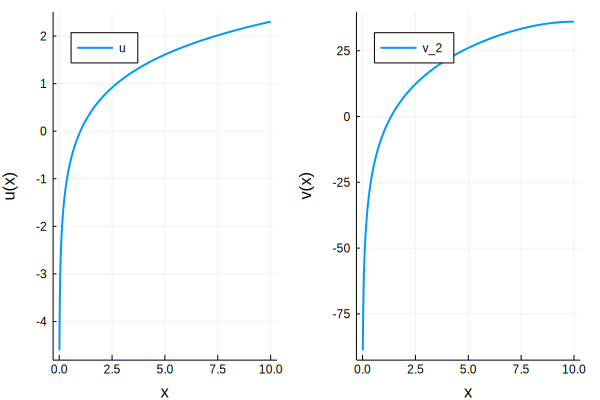

In [6]:
ρ = 0.05

v_2 = (ρ*I - A_2)\ u.(grid)

plt_u = plot(grid, u.(grid), label="u", xlabel="x", ylabel = "u(x)", lw=2, legend=:topleft)
plt_v2 = plot(grid, v_2, label="v_2", xlabel="x", ylabel="v(x)", lw=2, legend=:topleft)

plot(plt_u,plt_v2)

In [7]:
using Test

# We can verify that the solution v obtained with the linear operator from the SimpleDifferentialOperators package
# agrees with the solution v_2 obtained from manually discretizing the linear operator

@test v[1] ≈ v_2[1]
@test v[500] ≈ v_2[500]
@test v[999] ≈ v_2[999]

Test Passed